In [3]:
import torch as t
import matplotlib.pyplot as plt
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Controls as Controls
import Evolvers as Evolvers

from tqdm import tqdm
from time import time

In [4]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\Desktop\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [6]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	10,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  20,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

class QTrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.QTrotter, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        # self.alphas = alphas
        # self.control = control
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
QT = QTrotter(params_dict)

I added a factor half to the cosines


In [24]:
19*7*85

11305

In [7]:
adj = t.zeros((85,7,19,441)).cfloat()
alphas = t.linspace(0.5,1,85)
us = t.linspace(-0.02,0.02,7)
for i, alpha in enumerate(alphas):
    for j, u in enumerate(us):
        H = QT.get_H(alphas=t.tensor([alpha]),control=t.tensor([u])).squeeze()
        eigvals, eigvecs = t.linalg.eigh(H)
        adj[i,j] = eigvecs[:,:19].adjoint()

In [27]:
# dims = U0s.shape[1:]
dims = (Us.shape[-1],30)

class Basis(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.params = t.nn.parameter.Parameter(self.randc(dims))
    
    def randc(self,dims):
        return 2*(t.rand(dims) - 0.5) + 2j*(t.rand(dims) - 0.5)

    def normalize(self,basis):
        dot = (basis.adjoint()@basis).diagonal()
        return basis/dot.sqrt()

    def forward(self):
        return self.normalize(self.params)
    
    def Gram_Schmidt(self,basis):
        nb = t.zeros_like(basis)
        nb[:,0] = basis[:,0]
        for i in range(1,nb.shape[1]):
            nb[:,i] = basis[:,i] - (nb@nb.adjoint()@basis[:,[i]]).sum(1)
            nb[:,i] /= (nb[:,[i]].adjoint()@nb[:,[i]]).sqrt().squeeze()
        return nb

obj = Basis()

(0, 1.025)

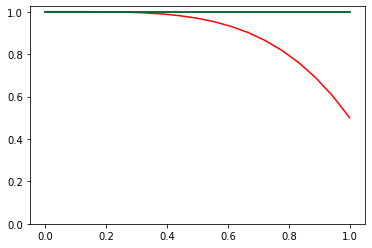

In [35]:
tmpx1 = t.linspace(0,1,19)
w1 = 1 - 0.5*tmpx1**4
w1 /= w1.sum()

tmpx2 = t.linspace(0,1,85)
w2 = t.ones(85)#(tmpx2-0.5)**2+1
w2 /= w2.sum()

tmpx3 = t.linspace(0,1,7)
w3 = t.ones(7)
w3 /= w3.sum()

plt.plot(tmpx1, w1/w1.max(),'r')
plt.plot(tmpx2, w2/w2.max(),'b')
plt.plot(tmpx3, w3/w3.max(),'g')
plt.ylim(0,None)

In [37]:
optimizer = t.optim.Adam(obj.parameters(),lr=1e-3)
loss_list = []

wLevels = w1.view(1,1,-1)#t.linspace(1,0.1,19)#t.exp(-0.5*t.arange(0,19,1))
wLevels /= wLevels.sum()

wAlphas = w2.view(-1,1,1)
wAlphas /= wAlphas.sum()

wUs = w3.view(1,-1,1)
wUs /= wUs.sum()

# def loss_func2(basis):
#     out = t.square((adj@basis).abs().square().sum(2) - 1)
#     out = out*wLevels*wAlphas
#     return out.sum()

def loss_func(basis):
    kets = adj.adjoint()
    proj = basis.adjoint()@kets
    inv = t.linalg.pinv(basis.adjoint())
    # rec = basis@proj
    rec = inv@proj
    diff = kets - rec
    out = t.square(diff.real) + t.square(diff.imag)
    # print(out.shape)
    out = out.mean(2)*wLevels*wAlphas*wUs
    # out = (weights*out).sum(2).mean()
    # out2 = t.mean(t.square(t.abs(basis.adjoint()@basis - t.eye(basis.shape[1]))))
    return out.sum() #+ out2

def epoch(N):
    for n in tqdm(range(N)):
        optimizer.zero_grad()
        loss = loss_func(obj())
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())


loss_func(obj())


tensor(0.0021, grad_fn=<SumBackward0>)

In [66]:
epoch(1000)

100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


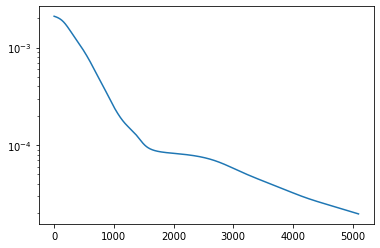

In [67]:
fig, ax = plt.subplots()
ax.plot(loss_list)
ax.set_yscale('log')

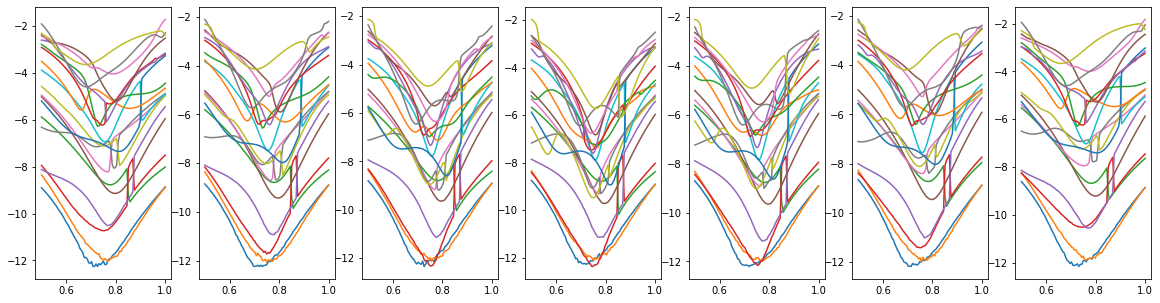

In [68]:
basis = obj().detach()
inv = t.linalg.pinv(basis.adjoint(),rtol=1e-100)
new_basis = obj.Gram_Schmidt(basis)

fig, ax = plt.subplots(figsize=(20,5),ncols=7)

occs = (adj@new_basis).abs().square().sum(3)

for i in range(ax.shape[0]):
    ax[i].plot(alphas,(1-occs[:,i]).log())


# ax.plot(tmp,(inv@basis.adjoint()@adj.adjoint()).abs().square().sum(1)[:,:]);
# ax.contour(us,alphas,);
# ax.set_yscale('log')
# ax.set_ylim(0.998,1)
# fig, ax = plt.subplots()
# tmp = t.linspace(1,0.5,85)
# ax.plot(tmp,(inv@basis.adjoint()@adj.adjoint()).abs().square().sum(1)[:,:]);
# ax.plot(tmp,(adj@new_basis).abs().square().sum(2)[:,:],linestyle='--');
# ax.set_yscale('log')
# ax.set_ylim(0.998,1)

In [20]:
SB2 = t.load("C:\\Users\\jv97\\Desktop\\github\\Quantum-Optimal-Control\\OptimizationIdeas\\OptimBasis2_30States.pt")
SB = t.load("C:\\Users\\jv97\\Desktop\\github\\Quantum-Optimal-Control\\OptimizationIdeas\\OptimBasis_30States.pt")

In [25]:
occs2 = (adj@SB2).abs().square().sum(3)
occs = (adj@SB).abs().square().sum(3)

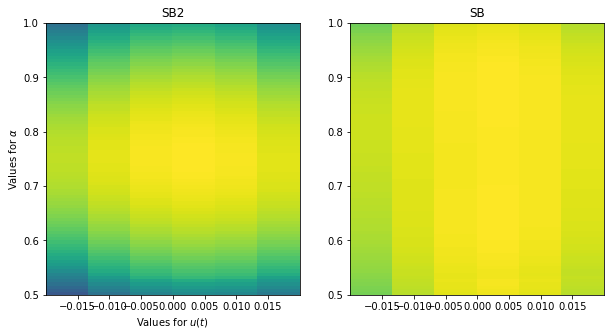

In [36]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
im2 = ax[0].pcolormesh(us,alphas,occs2.mean(2),shading='nearest',vmin=0.95)
ax[0].set(title='SB2')
ax[0].set_ylabel(r'Values for $\alpha$')
ax[0].set_xlabel(r'Values for $u(t)$')
ax[1].set(title="SB")
im = ax[1].pcolormesh(us,alphas,occs.mean(2),shading='nearest',vmin=0.95)
# fig.colorbar(im)
# fig.colorbar(im2)

In [71]:
# t.save(new_basis,"C:\\Users\\jv97\\Desktop\\github\\Quantum-Optimal-Control\\OptimizationIdeas\\OptimBasis2_30States.pt")

In [15]:
q = t.arange(-10,10+1,1)
XX, YY = t.meshgrid(q,q)

c:\Users\jv97\anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


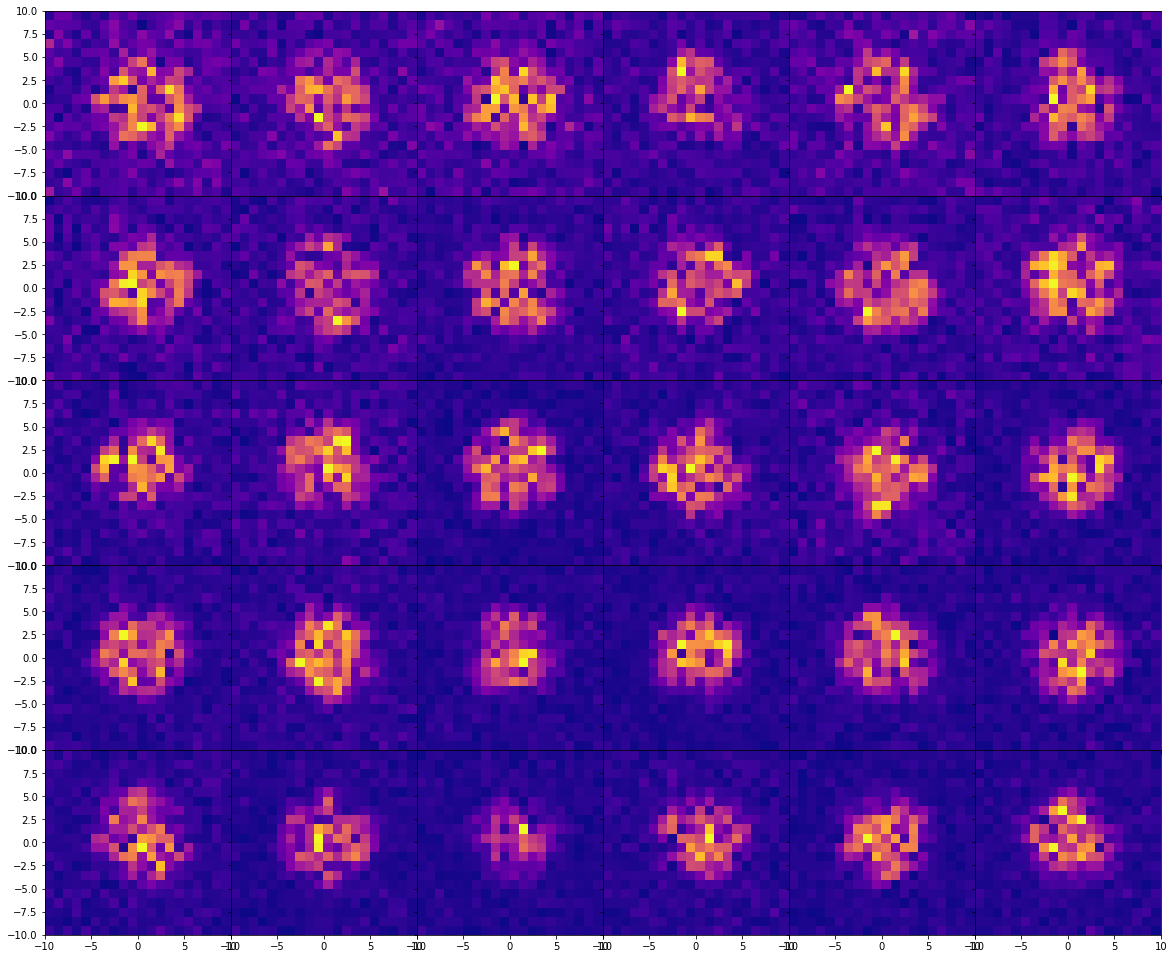

In [17]:
fig, ax = plt.subplots(figsize=(20,17),ncols=6,nrows=5,gridspec_kw={'hspace': 0,'wspace': 0},sharex=True,sharey=True)
ax = ax.flatten()
for i in range(ax.shape[0]):
    ax[i].pcolormesh(XX,YY,SB[:,i].view(21,21).abs(),shading='nearest',cmap="plasma")

tensor(0.8562)

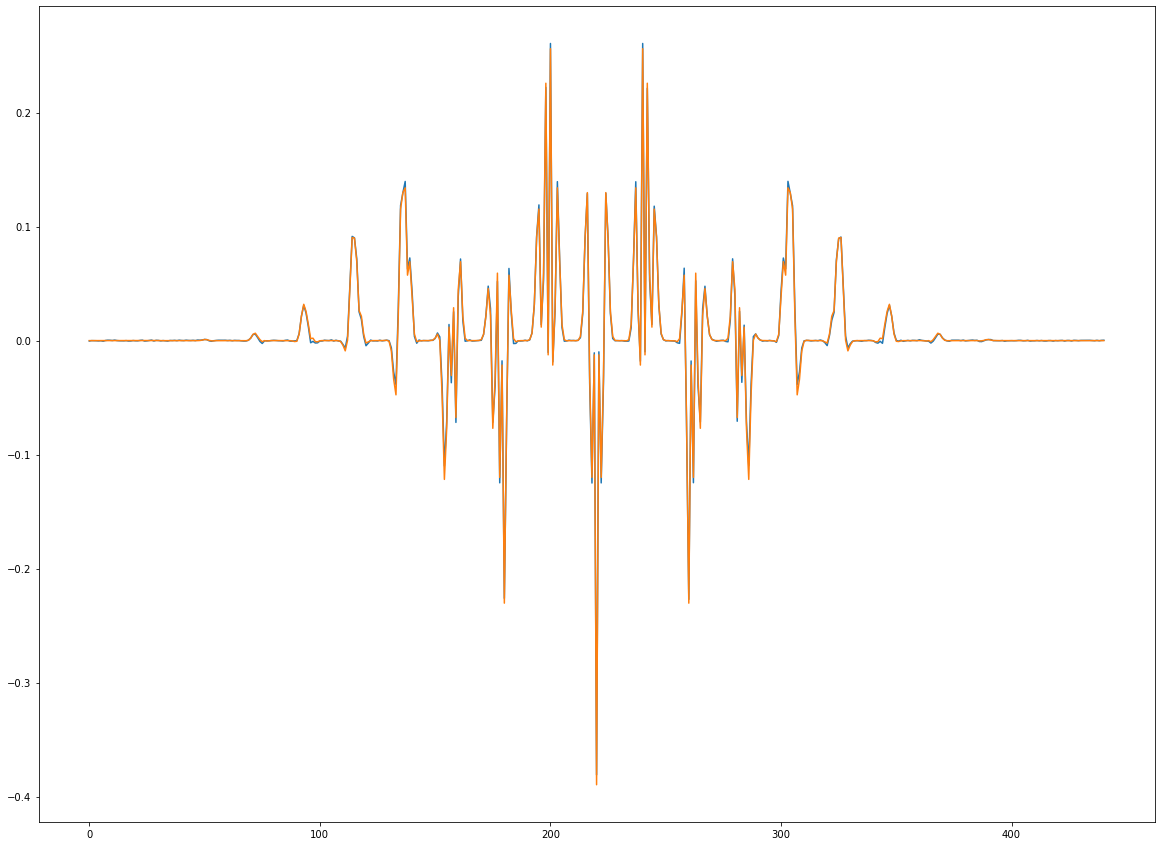

In [172]:
basis = obj().detach()
ket = adj.adjoint()[-1,:,[18]]
fig, ax = plt.subplots(figsize=(20,15))
overlap = basis.adjoint()@ket
sol = t.linalg.pinv(basis.adjoint(),rtol=1e-100)
ax.plot((sol@overlap).real)
ax.plot(ket.real)
overlap.abs().square().sum()
# ax.plot((basis*overlap.T).sum(1).abs())
# ax.plot(ket.abs())

In [173]:
params_dict = {'T':30,
               'NTrot': 1000,
               'q_max': 10,
               'subNHilbert':19,
               'dim': '2d',
               "phi_ext": 3.132167875629024,
                "EJ": 		62.83185307179586,
                "EC": 		0.6283185307179586,}

class Model(Systems.Periodic_System):
    def __init__(self):
        self.params_dict = params_dict
        super().__init__()
        
        self.basis = self.Gram_Schmidt(obj().detach())
        sol = self.basis
        # self.basis = obj().detach()
        # sol = t.linalg.pinv(self.basis.adjoint(),rtol=1e-100)#t.linalg.lstsq(self.basis.adjoint(),t.eye(19).cfloat()).solution
        # self.basis = adj[0].adjoint()
        # sol = adj[0].adjoint()
        self.M1 = self.basis.adjoint()@self.cos_mat@sol
        self.M2 = self.basis.adjoint()@self.cos2_mat@sol
        self.M3 = self.basis.adjoint()@self.q_mat@sol
        self.KINE = self.basis.adjoint()@self.KinE@sol
        self.sol = sol

        # self.M1 = self.cos_mat
        # self.M2 = self.cos2_mat
        # self.M3 = self.q_mat
        # self.KINE = self.KinE
        # self.basis = t.eye(441)
        # self.sol = t.eye(441)
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

    def get_H(self,alphas=t.tensor([1]),control = t.tensor([0])):
        return self.KinE.repeat((alphas.shape[0],1,1)) + self.V(alphas=alphas,control=control)
    
    def forward(self,alphas=t.tensor([1]),control=t.tensor([0])):
        from time import time
        self.alphas = alphas
        V = self.EJ*(-self.M1.repeat((alphas.shape[0],1,1)) - alphas.view(-1,1,1)*self.M2 + control.view(-1,1,1)*self.M3)
        H = self.KINE.repeat((alphas.shape[0],1,1)) + V
        print("Matrix exp..")
        start = time()
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        print("Took: " + str(time() - start))
        # self.latest_matrix_exp = self.basis_change@t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def get_occupancy(self, indices = [0,1], init_inds = [0,1]):

        occ = t.zeros((len(indices)+1,self.alphas.shape[0],len(init_inds)))
        wavefuncs = (self.basis.adjoint()@adj[0].adjoint()[:,init_inds])

        
        for i, mat in enumerate(self.latest_matrix_exp):
            wavefuncs = mat@wavefuncs
            for j, ind in enumerate(indices):
                occ[j,i] = t.abs(self.eigvecs[i,:,[ind]].adjoint()@self.sol@wavefuncs)
                # occ[j,i] = t.abs(wavefuncs[ind])
        occ = t.square(occ)
        occ[len(indices)] = 1-occ.sum(0)
        return occ.squeeze()
    
    def Gram_Schmidt(self,basis):
        nb = t.zeros_like(basis)
        nb[:,0] = basis[:,0]
        for i in range(1,nb.shape[1]):
            nb[:,i] = basis[:,i] - (nb@nb.adjoint()@basis[:,[i]]).sum(1)
            nb[:,i] /= (nb[:,[i]].adjoint()@nb[:,[i]]).sqrt().squeeze()
        return nb

model = Model()

I added a factor half to the cosines


In [29]:
# plt.imshow((basis.adjoint()@basis).detach().abs()-t.eye(30))
# plt.colorbar()
# plt.figure()
# plt.imshow((new_basis.adjoint()@new_basis).detach().abs()-t.eye(30))
# plt.colorbar()

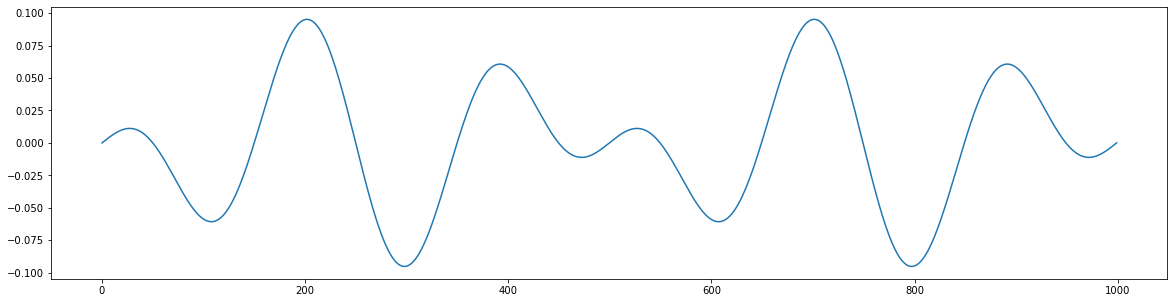

In [107]:
times = t.linspace(0,30,1000)
control = 0.1*t.sin(2*t.pi/30*times)*t.cos(5*2*t.pi/30*times)
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(control)

Eigh..
It took:22.815751791000366


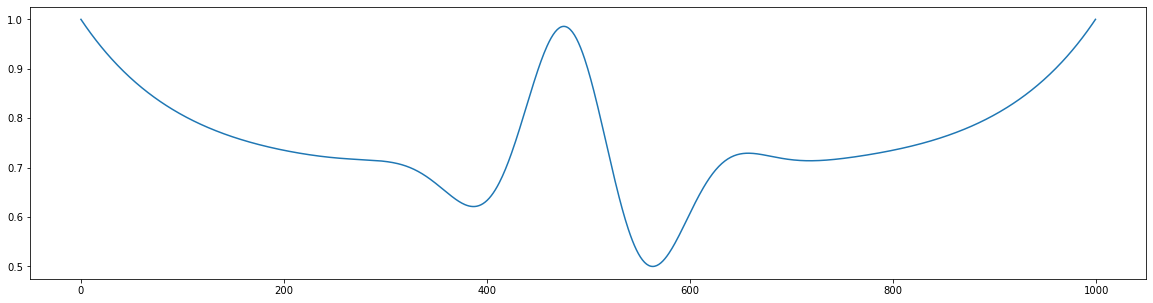

In [48]:
times = t.linspace(0,30,1000)
alphas = t.sin(times)*t.exp(-(times-15)**2/10) + t.exp(-times/3) + t.exp(-(30 - times)/3)
alphas = alphas - alphas.min()
alphas = alphas/alphas.max()/2
alphas = alphas + 0.5
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(alphas)

print("Eigh..")
start = time()
eigvals, eigvecs = t.linalg.eigh(model.get_H(alphas=alphas.detach())) #This is probably what makes alpha regression slow
print("It took:" + str(time()-start))
eigvecs = eigvecs.cfloat()

In [194]:
eigvecs.shape

torch.Size([1000, 441, 441])

In [174]:
model.eigvecs = eigvecs

In [177]:
model.forward(alphas,control)
# occ = model.get_occupancy()
# tmp_occ = model.get_occupancy()
tmp_occ2 = model.get_occupancy()
# occ2 = model.get_occupancy([_ for _ in range(18)], [0,1])

Matrix exp..
Took: 0.10703396797180176


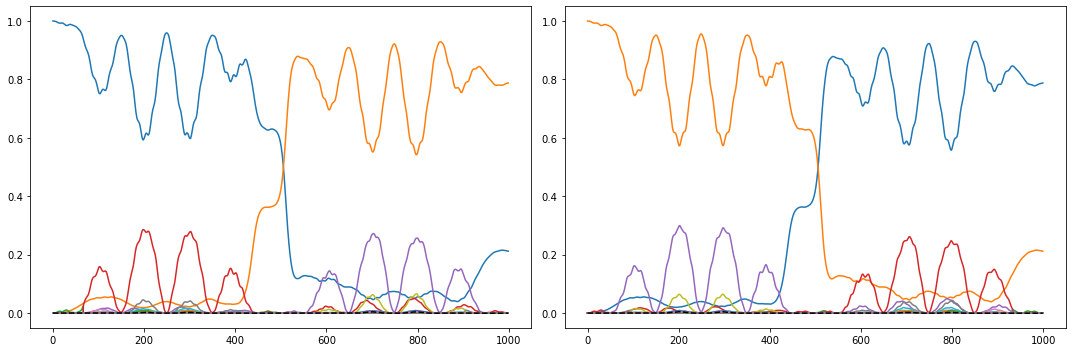

In [176]:
fig, ax = plt.subplots(figsize=(15,5),ncols=2)
# for i in range(2):

ax[0].plot(occ2[:-1,:,0].T)
ax[0].plot(occ2[-1,:,0],'k--')

ax[1].plot(occ2[:-1,:,1].T)
ax[1].plot(occ2[-1,:,1],'k--')
fig.tight_layout()

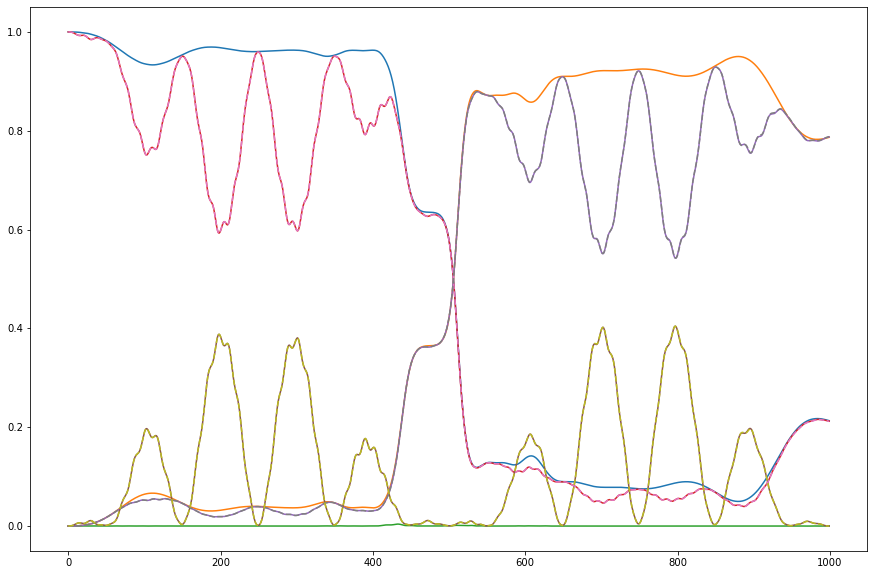

In [178]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(occ[:,:,0].T);
ax.plot(tmp_occ[:,:,0].T);
ax.plot(tmp_occ2[:,:,0].T,linestyle='--');

In [190]:
# basis = model.basis.detach()
# t.save(basis,"C:\\Users\\jv97\\github\\Quantum-Optimal-Control\\OptimizationIdeas\\OptimBasis_30States.pt")

In [205]:
tmp = t.zeros((2,2))
for i in range(2):
    for j in range(2):
        tmp[i,j] = occ[i,-1,j]
tmp
tmp2 = t.zeros((2,2))
tmp2[0,1] = tmp2[1,0] = 1
1-t.square(t.abs(t.trace(tmp2@tmp)))/2**2

tensor(0.3813)